# Expanding Variable Cluster Timeline

Author: Sofia Ingersoll 5 May 2024

## Increaseing Timeline
Loading files in 4, 500 cluster chunks 
`campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0113.clm2.h0.1995-02-01-00000.nc`


**Help**
- It's taking too long to complete the task, so I'm not sure these are viable approaches

In [6]:
import xarray as xr
import pickle
from utils import * 

In [7]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46279 instead
  warnings.warn(


Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/46279/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.102:37385,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/46279/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
cluster_lists = [
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.1995-02-01-00000.nc')[1:]),
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2000-02-01-00000.nc')[1:]),
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc')[1:]),
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2010-02-01-00000.nc')[1:])
    ]

In [9]:
def read_all_simulations2(var):
    '''Prepare cluster list and read to create ensemble(group of data)
    Use preprocess to select only certain dimension and a variable'''
    # Define the list of lists
    cluster_lists = [
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.1995-02-01-00000.nc')[1:]),
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2000-02-01-00000.nc')[1:]),
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc')[1:]),
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2010-02-01-00000.nc')[1:])
    ]
    
    def preprocess(ds, var):
        '''using this function in xr.open_mfdataset as preprocess
        ensures that when only these four things are selected 
        before the data is combined'''
        return ds[['lat', 'lon', 'time', var]]
    
    #read the list and load it for the notebook
    ds = xr.open_mfdataset( cluster_lists, 
                            combine='nested',
                            preprocess = lambda ds: preprocess(ds, var),
                            parallel= True, 
                            concat_dim= ["time", "ens"])
    return ds

In [ ]:
# this ran and the outputs are closer to what we expect
# WE OFFICIALLY HAVE 1995 - 2015
read_all_simulations2("LNC")

### Testing Other Functions!

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This is where 
# read_all_simulations appears in wkflw
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def subset_var_cluster2(var):
    '''Subset the selected variable 
    (s) between 2005-2010 [for now, will be time range]
    as a xr.da.'''
    
    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations2(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]

    return da.compute()

In [12]:
def read_n_wrangle2(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # store user-inputs as global variables
    # will call later for plotting
    global param_name, var_name
    param_name = param
    var_name = var
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # pull in parameter data
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
 #   filepath = os.path.join("saves", f"{var}.nc")
  #  if os.path.exists(filepath):
   #      #read in the file as a dataset
    #    ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
    #    var_avg = ds[var]
    #else:
     #   print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var_da = subset_var_cluster2(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
    ds = var_avg.to_dataset(name = var)
    # note that this will throw error if you try to overwrite existing files
    ds.to_netcdf('saves/'+var+'.nc') 

    return params, var_avg, param_name, var_name

In [19]:
# this takes about 2 minutes to run
param2, var2, param_name, var_name = read_n_wrangle2("leafcn","LNC")

In [22]:
var2.shape
var2

<xarray.DataArray (ens: 500)> Size: 4kB
array([0.84724795, 1.00483139, 0.94270426, 0.80605579, 1.1128554 ,
       0.80453896, 0.89947509, 1.17311634, 1.07390253, 1.15246407,
       0.95042113, 0.92575337, 0.88109323, 0.80037626, 0.69054404,
       0.91848529, 0.65470052, 0.84413694, 0.74928195, 0.76841898,
       1.00849537, 1.03304884, 0.96510496, 0.64508573, 0.62692846,
       0.8113084 , 0.89804134, 0.68622747, 0.99803847, 0.88498184,
       0.84298645, 0.5668954 , 0.7940038 , 0.90598016, 0.83229929,
       0.99533558, 0.71565572, 1.14975743, 0.92956121, 0.70375154,
       0.58010059, 1.4550065 , 0.88190826, 0.86925358, 0.80250983,
       1.11572008, 0.74331942, 1.28283612, 0.73988352, 0.75966279,
       0.65763585, 0.8046558 , 0.95892461, 0.88531088, 0.65444614,
       0.97957942, 0.7479346 , 0.71812983, 1.06881471, 0.90273297,
       0.79920299, 0.62173263, 0.98091734, 1.12732736, 1.33402347,
       0.68673104, 0.6494072 , 0.63943977, 0.98593471, 0.73027378,
       0.72652661, 0.80384012, 0.81317768, 0.77835292, 0.78781872,
       1.03507916, 0.94566245, 0.68810733, 0.98332559, 0.94890132,
       0.92930338, 0.83250592, 0.65115088, 0.68892735, 0.72897511,
       0.74347807, 0.90626856, 0.84113732, 0.64418143, 0.82029234,
       1.08348749, 1.01929107, 1.0676975 , 1.00651474, 0.73968505,
       0.82355822, 0.78825986, 0.7792202 , 0.74184539, 0.64874909,
...
       0.5250748 , 0.91113726, 0.51218591, 0.90333593, 0.7186534 ,
       0.79830829, 0.85684721, 1.081304  , 1.09184664, 1.03069391,
       1.09396823, 1.03482179, 1.0899302 , 0.63589392, 0.99895348,
       1.08101282, 0.59851473, 0.95873581, 1.30624742, 0.68579923,
       0.73116038, 0.85341234, 0.89935879, 0.9106108 , 0.80627532,
       1.01398352, 0.72410183, 0.5902345 , 0.71129542, 0.6737649 ,
       0.9677413 , 0.85272023, 0.71096648, 0.87338698, 0.71629044,
       0.6119169 , 0.94932187, 0.60251337, 0.81745168, 0.87549494,
       0.75713172, 0.78749476, 0.86230202, 0.68574534, 0.55478205,
       0.98228629, 0.69014263, 0.56071103, 1.04437843, 0.84640924,
       0.93341076, 0.83494983, 1.08701967, 0.86300214, 0.66339375,
       0.51969231, 1.07132359, 0.58470903, 0.89186424, 0.67423432,
       0.93366672, 1.22330245, 0.79440031, 0.9491069 , 0.58697589,
       0.77379369, 0.65677785, 1.01295791, 0.55110768, 0.71357092,
       1.11226806, 0.90559835, 0.96262743, 0.99207887, 0.63474586,
       0.92134597, 0.72771233, 0.64391178, 0.89087412, 0.57595648,
       0.94136548, 0.53802087, 1.24665817, 1.00894514, 0.93981805,
       1.10759742, 0.94279827, 1.42957106, 0.65637618, 1.13095786,
       0.59948692, 0.965988  , 0.8184049 , 0.82870161, 0.67934924,
       0.74236659, 0.76305159, 0.96460325, 0.52084213, 0.96982045])
Dimensions without coordinates: ens

**The var dim post wrangling is ens.**

In [17]:
# this takes about 2 minutes to run
param, var, param_name, var_name = read_n_wrangle("leafcn","LNC")

In [21]:
var.shape
var

<xarray.DataArray 'LNC' (ens: 500)> Size: 4kB
[500 values with dtype=float64]
Dimensions without coordinates: ens

In [32]:
param.shape

(500, 32)

### Expanding Emulator Capabilities
We want to iterate through all perturbed parameters to train the emulator

In [32]:
def train_emulator2(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----   Load Pickled Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   # work in progress in GaiaFuture/Scripts/ML/Gaussian/gpr_pickling.ipynb
    # if it's already been queried and saved, pull it!
    # tis only names properly when inside dashboard function
    # commenting out now and adapting bc var is xr.da in this case
    filename = os.path.join("emulation_results", f"gpr_model_{var_name}_{param_name}.sav")
   
    #if os.path.exists(filename):
        # load the model from disk
     #   loaded_model = pickle.load(open(filename, 'rb'))
        
   # else:
    #    print(f"Emulator is running, this may take a few moments")
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))
   
   
     # using an out of the box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel,
                                        # want 20 random starts
                                        n_restarts_optimizer=20,
                                        # setting seed
                                        random_state=99,
                                        normalize_y=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gpr_model = gpr_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gpr_model.predict(X_test, return_std=True)


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    #train_score = gpr_model.score(X_train, y_train)

    # Accuracy Score
    #accuracy = accuracy_score(y_test, y_pred)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate R^2
    r2_emulator = np.corrcoef(y_test, y_pred)[0,1]**2
    
    # Calculate RMSE
    rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_emulator
    results_df['RMSE'] = rmse_emulator
    #results_df['Accuracy Score'] = accuracy
    results_df['Mean Absolute Error'] = mae
    
   
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Pickle Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # save the model to disk
    pickle.dump(gpr_model, open(filename, 'wb')) 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Print Metrics         ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Print Training Metrics
    print("R^2:", r2_emulator)
    print("RMSE:", rmse_emulator)
    print("Mean Absolute Error:", mae)
   # print("Training Score:", train_score)
    
    return gpr_model, y_pred, y_std, y_test, X_test, r2_emulator

In [34]:
gpr_model, y_pred, y_std, y_test, X_test, r2_emulator = train_emulator2(param2, var2)

R^2: 0.5655127320139837
RMSE: 0.11588981489701396
Mean Absolute Error: 0.08540175880876319


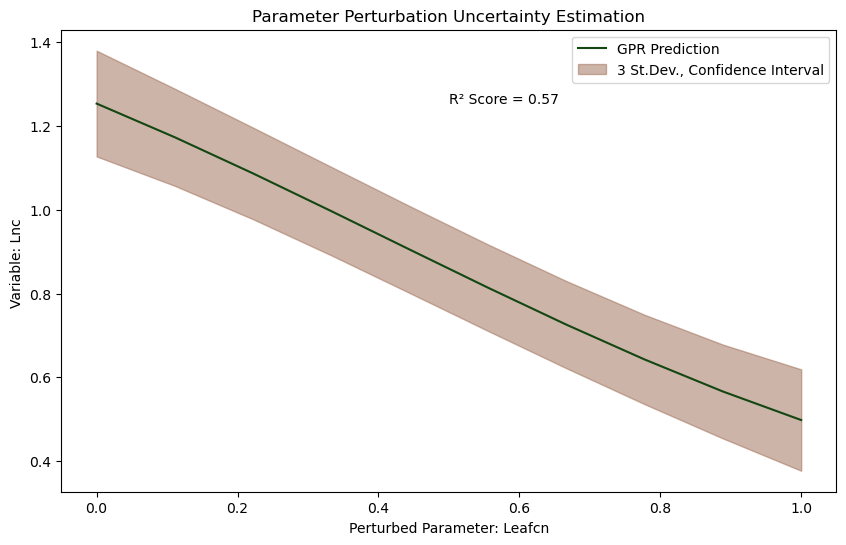

In [35]:
plot_emulator(gpr_model, y_test, r2_emulator)

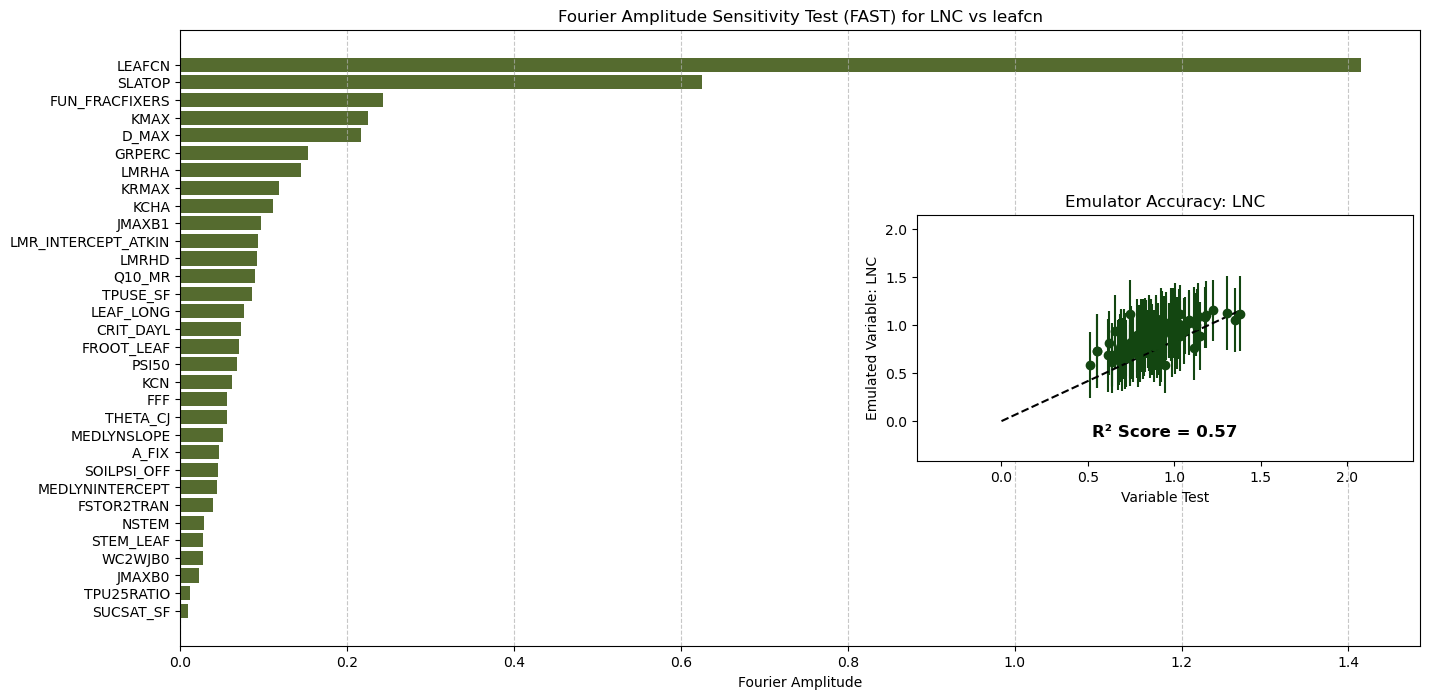

In [36]:
plot_FAST_accuracy(gpr_model, r2_emulator, y_test, y_pred, y_std)

In [ ]:
def create_parameter_names_dict():
    data = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    return data


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))
   


 for param_index in range(32):
     # this needs to be X_train data for each parameters to iterate thru
            X_values = np.full((10, 32), 0.5)
            X_values[:, param_index] = np.linspace(0, 1, 10)
            y_pred, _ = gpr_model.predict(X_values, return_std=True)



 # using an out of the box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel,
                                        # want 20 random starts
                                        n_restarts_optimizer=20,
                                        # setting seed
                                        random_state=99,
                                        normalize_y=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gpr_model = gpr_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gpr_model.predict(X_test, return_std=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate R^2
    r2_emulator = np.corrcoef(y_test, y_pred)[0,1]**2
    
    # Calculate RMSE
    rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))
   
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Pickle Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # save the model to disk
    pickle.dump(gpr_model, open(filename, 'wb')) 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Print Metrics         ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Print Training Metrics
    print("R^2:", r2_emulator)
    print("RMSE:", rmse_emulator)
    print("Mean Absolute Error:", mae)


    sorted_indices = np.argsort(y_pred, y_std)
    sorted_parameter_emulations = np.array(y_pred, y_test)[sorted_indices]
    swapped_param_keys = {v: k for k, v in create_parameter_names_dict().items()}
    sorted_parameter_names = [swapped_param_keys[index] for index in sorted_indices]

    
    return gpr_model, y_pred, y_std, y_test, X_test, r2_emulator

In [38]:
def train_emulator2(param, var):
    def create_parameter_names_dict():
        data = {
            key.upper(): value for key, value in {
                'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
                'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
                'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
                'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
                'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
                'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
            }.items()
        }
        return data

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(param, var, test_size=0.2, random_state=0)

    # Define the kernel
    kernel = ConstantKernel(constant_value=3, constant_value_bounds=(1e-2, 1e4)) \
              * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))

    # Iterate through each parameter index
    for param_index in range(32):
        # Initialize the model
        gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=99, normalize_y=True)
        
        # Select the parameter to perturb
        X_values[:, param_index] = X_train[:, param_index]  # Perturb the selected parameter
        
        # Fit the model to the training data
        gpr_model.fit(X_values, y_train)

        # Make predictions on the test data
        y_pred, y_std = gpr_model.predict(X_test, return_std=True)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2_emulator = np.corrcoef(y_test, y_pred)[0, 1] ** 2
        rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))

        # Print metrics
        print(f"Parameter: {param_index}, R^2: {r2_emulator}, RMSE: {rmse_emulator}, MAE: {mae}")

        # Save the model to disk
        filename = f"gpr_model_param_{param_index}.pkl"
        pickle.dump(gpr_model, open(filename, 'wb'))
        
        return gpr_model, y_pred, y_std, y_test, X_test, r2_emulator

In [44]:
def train_emulator2(param, var):
    def create_parameter_names_dict():
        data = {
            key.upper(): value for key, value in {
                'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
                'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
                'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
                'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
                'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
                'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
            }.items()
        }
        return data

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(param, var, test_size=0.2, random_state=0)

    # Define the kernel
    kernel = ConstantKernel(constant_value=3, constant_value_bounds=(1e-2, 1e4)) \
              * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))

    # Iterate through each parameter index
    for param_index in range(32):
        # Initialize the model
        gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=99, normalize_y=True)
        
        # Perturb the selected parameter
        X_values = X_train[:, param_index]
        
        # Fit the model to the training data
        gpr_model.fit(X_values, y_train)

        # Make predictions on the test data
        y_pred, y_std = gpr_model.predict(X_test, return_std=True)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2_emulator = np.corrcoef(y_test, y_pred)[0, 1] ** 2
        rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))

        # Print metrics
        print(f"Parameter: {param_index}, R^2: {r2_emulator}, RMSE: {rmse_emulator}, MAE: {mae}")

        # Save the model to disk
        filename = f"gpr_model_param_{param_index}.pkl"
        pickle.dump(gpr_model, open(filename, 'wb'))
        
    return gpr_model, y_pred, y_std, y_test, X_test, r2_emulator

In [45]:
gpr_model, y_pred, y_std, y_test, X_test, r2_emulator = train_emulator2(param2, var2)

ValueError: Expected 2D array, got 1D array instead:
array=[0.22896232 0.33482249 0.16317696 0.8446037  0.34763862 0.53181485
 0.8168225  0.13901352 0.68197758 0.02060352 0.02738171 0.1455095
 0.09127656 0.83671342 0.04927065 0.83442282 0.94687092 0.8338806
 0.99117142 0.02420829 0.73086703 0.56347196 0.5927116  0.485184
 0.90951128 0.41185945 0.6146369  0.37479017 0.49077137 0.40749089
 0.85398452 0.63623534 0.70464876 0.21891698 0.30409088 0.26465227
 0.29853327 0.65090385 0.67470632 0.60873817 0.09955461 0.60301839
 0.3401772  0.89820097 0.66539821 0.04513481 0.95387946 0.12473855
 0.98928014 0.29560403 0.17689381 0.43600169 0.62929864 0.60196301
 0.54725141 0.44843561 0.21557021 0.23210261 0.63912256 0.8737026
 0.98360086 0.05745631 0.94948247 0.06740423 0.10621479 0.76023459
 0.72943083 0.60725877 0.42211367 0.63209216 0.14657595 0.14896061
 0.90681542 0.16887709 0.95547909 0.64624532 0.25338599 0.70956271
 0.19881193 0.31695016 0.51828493 0.88074464 0.25744302 0.18989438
 0.4272818  0.15585601 0.30073536 0.3818911  0.30704516 0.54888565
 0.25896507 0.71954883 0.3897872  0.4776228  0.93147368 0.88636189
 0.02832672 0.44435086 0.36105872 0.87179083 0.17056244 0.03421368
 0.8310604  0.45015435 0.79533397 0.2836004  0.76471898 0.78274539
 0.98571566 0.57494077 0.93520607 0.94257867 0.5272611  0.08556735
 0.87677181 0.40075984 0.07813153 0.8848868  0.56611627 0.11384315
 0.33136212 0.04721125 0.82048689 0.33647247 0.76814956 0.97347145
 0.49373642 0.73379229 0.49753348 0.21327266 0.92861541 0.0710399
 0.45685737 0.36591719 0.82636957 0.09233946 0.91586334 0.6733127
 0.9023751  0.4080905  0.35684341 0.07639246 0.84717309 0.44244714
 0.61764672 0.44727047 0.37175365 0.92659735 0.23470441 0.06815519
 0.13538951 0.1675765  0.63499853 0.82212248 0.03867638 0.29723061
 0.8133518  0.39070094 0.64031798 0.17553891 0.03601428 0.52826262
 0.48364154 0.81029819 0.86439779 0.94503682 0.42479557 0.87537083
 0.56814137 0.90480674 0.45863672 0.95980828 0.99398642 0.72448451
 0.44173285 0.71679379 0.99418643 0.36319738 0.77215386 0.58977113
 0.54570584 0.00590844 0.56468539 0.06001622 0.00834736 0.28787572
 0.86787636 0.1783275  0.09680672 0.57013338 0.48835019 0.65849084
 0.11687764 0.93983917 0.82491396 0.49919291 0.92348387 0.76220617
 0.5327578  0.40214688 0.56173061 0.68536084 0.06585436 0.1410238
 0.59919475 0.69122383 0.58484127 0.97141263 0.43241381 0.18596905
 0.66198277 0.92460327 0.80390381 0.43962319 0.90175798 0.36611183
 0.99893565 0.20161398 0.97919941 0.69708218 0.69575428 0.47063294
 0.60464248 0.93631734 0.8011082  0.30244697 0.00716927 0.29352281
 0.23936433 0.12074541 0.88887091 0.39891217 0.48027269 0.41205094
 0.27659278 0.79165625 0.26773427 0.72614924 0.75768653 0.74128937
 0.96428895 0.1058698  0.78527879 0.48644242 0.51534111 0.52077943
 0.20314684 0.29146979 0.66252644 0.98622467 0.46507307 0.25484902
 0.84348489 0.2490585  0.85934986 0.99688627 0.76737926 0.32267789
 0.73439888 0.61920603 0.13643621 0.74913781 0.35599834 0.09504263
 0.79372964 0.86984116 0.51381514 0.22075272 0.78729651 0.53563206
 0.12665332 0.9636731  0.20425639 0.77831114 0.53723021 0.31427369
 0.08844651 0.9802442  0.27802109 0.78007696 0.91245471 0.07333996
 0.39467474 0.85667226 0.22684026 0.04250402 0.10177461 0.86317729
 0.2469984  0.10356133 0.31004146 0.78861777 0.10869644 0.97446265
 0.6454089  0.32530123 0.66703371 0.21025614 0.84833469 0.64297252
 0.28844359 0.50554095 0.94023584 0.73854447 0.26212961 0.032014
 0.54223794 0.69979827 0.34836178 0.47541689 0.41936365 0.11844364
 0.42988286 0.11426617 0.43568624 0.62714547 0.58747566 0.37972137
 0.46368009 0.71532934 0.50078849 0.89499925 0.01582858 0.34286811
 0.72246241 0.86165002 0.47801938 0.05236443 0.15646531 0.33240616
 0.96987231 0.21726589 0.74340548 0.04046736 0.0876173  0.51083725
 0.27375575 0.41498243 0.32665988 0.35884124 0.1517712  0.67846837
 0.26865839 0.17259166 0.38241688 0.55307771 0.9604917  0.06349214
 0.71027635 0.46764166 0.65324114 0.02316707 0.5025155  0.74529706
 0.85013778 0.62461589 0.01728557 0.0803733  0.75928478 0.46907014
 0.32873605 0.34594539 0.43185838 0.24526179 0.68734805 0.14238744
 0.33948738 0.65775788 0.13204159 0.31274028 0.35354939 0.2711975
 0.4526174  0.77181711 0.18769168 0.18345745 0.37656103 0.80977562
 0.9662959  0.23107721 0.393992   0.26017637 0.59721932 0.28033308
 0.62110291 0.77787389 0.83809132 0.82976694 0.77457002 0.01854491
 0.75069438 0.40529083 0.12383858 0.6311306  0.67112807 0.46193623
 0.08350086 0.07484642 0.58229602 0.35058853].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Improving Func Integration 
It would be beneficial to move our if else statement outside of the `read_n_wrangle()` and directly into the `read_all_simulations()` because it doesn't need to depend on the parameter / variable combination bc the param data is the same for all sims. 

Next step, adding this into the function above once we're able to improve the computational speed of `read_all_simulations()`

In [ ]:
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")